In [1]:
import numpy as np
from scipy import fftpack
from scipy import ndimage

import base64
import pylab as py
import matplotlib.pyplot as plt
import matplotlib.animation as animation
plt.rcParams['animation.ffmpeg_path'] = '/home/vasha/anaconda3/bin/ffmpeg'

import matplotlib as mpl
import matplotlib.gridspec as gsp
import imageio
import cv2

%matplotlib inline
%config InlineBackend.print_figure_kwargs = {'dpi' : 100} #plotting pretty

In [2]:
def readMov(path, maxframes, startframe=0):
    """
    Reads in a movie chunk form the van Hatteren database.

    Parameters
    ----------
    path  :   string indicating filepath to read from 
    frames:   integer subset number of frames to take from movie   
    
    Returns
    -------
    d       : numpy matrix with pixel values for movie.
    
    """
    
    if('vanHaterenNaturalMovies' in path):
        with open(path, 'rb') as fid:
            #read in movie
            d = np.fromfile(fid, np.dtype('uint8'))
            nframes = int(9600/2)
            rawframeh = 128
            rawframew = 128
            barwidth = 16
            framew = rawframew - barwidth #in pixels
            frameh = rawframeh - barwidth #in pixels

            #put data back into a movie shape
            d = np.reshape(d,(int(nframes*2),rawframeh,rawframew))
            #remove black bar from top, and make the other side even too
            d = d[:,barwidth:,int(barwidth/2):-int(barwidth/2)]
            #print(np.shape(d))
            #average each of 2 frames together
            #d = np.uint8((d[1::2,]+d[::2,])/2)
            #print(np.shape(d[1::2,]))
            d = np.mean(np.array([d[::2,],d[::2,]]),axis=0)
            
    if('cheetah' in path):
        d = []
        reader = imageio.get_reader(path,'ffmpeg')
        for im in reader:
            d.append(im)
        d = np.array(d)[startframe:startframe+600]
        
    if('Nature' in path):
        d = []
        reader = imageio.get_reader(path,'ffmpeg')
        for im in reader:
            d.append(im)
        d = np.array(d)[startframe:]
        
        #crop out the watermark
        d = d[:,:,200:,:]
    if('Stationary' in path):
        #from: https://stackoverflow.com/questions/42163058/how-to-turn-a-video-into-numpy-array
        cap = cv2.VideoCapture(path)
        frameCount = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
        frameWidth = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
        frameHeight = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
        
        #lower our framecount if we don't want whole movie
        frameCount = np.min([frameCount,maxframes])

        d = np.empty((frameCount, frameHeight, frameWidth, 3), np.dtype('uint8'))
        fc = 0
        ret = True

        while (fc < frameCount and ret):
            ret, frame = cap.read()
            #frame = cv2.flip(frame,0) 
            d[fc] = frame
            fc += 1

        cap.release()
            

    return(d)

In [3]:
def fr2ms(frames, fps):
    ms = (float(frames) * 1000)/fps
    return(ms)

def ms2fr(ms, fps):
    frames = (float(ms)*fps)/1000
    frames = int(np.round(frames,decimals=0))
    if(frames==0):
        frames=1
    return(frames)

def px2degfull(px):
    """
    Converts pixels on my 15" macbook pro at 18" viewing dist to degrees on retina
    Usefull in converting cycles per pixel -> cycles per degree
    
    Parameters
    ----------
    px: integer pixels
 
    Returns
    -------
    degrees : float value for degrees
    
    """
    d = 18 #viewing distance in inches
    ppi = 227 #my macbook - other 132.07 #pixels per inch
    inches = px/ppi
    
    visang = 2 * (180/np.pi) * np.arctan(inches/2/d)
    
    return(visang)


In [4]:
#fpath = '/home/vasha/datasets/vanHaterenNaturalMovies/vid075' #25 fps
#fps = 25 #approximated from http://redwood.berkeley.edu/bruno/data/vid075/README
#ncolorchannels = 1

#fpath = '/home/vasha/datasets/cheetahlongclip.mp4' #30fps
#fpath = '/home/vasha/datasets/YouTubeDownloads/TigerShake.mp4'#60fps
fpath = '/home/vasha/datasets/YouTubeDownloads/Nature60_firstbit.mp4'#60fps 
fps = 60

#fpath = '/home/vasha/datasets/Berkeley_Stationary_Motion/VID_20180220_083139.mp4'
#fps = 240
ncolorchannels = 3

ppd = 1./px2degfull(1)

#read in movie
m = readMov(fpath, maxframes=480, startframe=0)
#print(np.shape(m))
nframes, frameh, framew, ncolorchannels= np.shape(m)

#convert to degrees
framewdeg = framew/ppd 
framehdeg = frameh/ppd
#sampling rate
deltawdeg = 1./ppd
deltahdeg = 1./ppd 
deltathz = 1./fps

# spots in movie
srun = 0
mrun = 99

#Do we want animations?
anim_flag=False

#mm = m - np.mean(m,axis=(1,2)).reshape(-1,1,1)
#calc vectorized version
#vlen = framew * frameh
vm = np.reshape(m,(nframes,-1,m.shape[3]))

Shape of m is (540, 720, 1080, 3)
Movie is set at 60 FPS


Text(0,0.5,'deg')

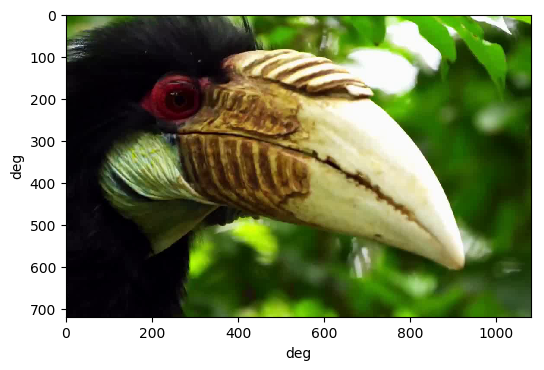

In [5]:
#show a sample image
def getsim(idx):
    sampleim = m[idx]
    return(sampleim)
    
#plt.imshow(sampleim,cmap='gray') #doesn't look quite as good.
#fig = plt.imshow(getsim(lion),cmap='Greys_r') #this map looks a bit better.

print('Shape of m is {}'.format(m.shape))
print('Movie is set at {} FPS'.format(fps))

fig, ax = plt.subplots()
showim = getsim(srun) #- getsim(lion+1)
ax.imshow(showim,aspect='auto')
ax.set_xlabel('deg')
ax.set_ylabel('deg')

In [7]:
## helper functions for animation

##embed animation as html

from tempfile import NamedTemporaryFile

VIDEO_TAG = """<video controls>
 <source src="data:video/x-m4v;base64,{0}" type="video/mp4">
 Your browser does not support the video tag.
</video>"""

def anim_to_html(anim):
    if not hasattr(anim, '_encoded_video'):
        with NamedTemporaryFile(suffix='.mp4') as f:
            anim.save(f.name, fps=24, extra_args=['-vcodec', 'libx264'])
            video = open(f.name, "rb").read()
        anim._encoded_video = base64.b64encode(video).decode('utf-8')
    
    return VIDEO_TAG.format(anim._encoded_video)

from IPython.display import HTML


#function we can call to animate with HTML
def display_animation(anim):
    plt.close(anim._fig)
    return HTML(anim_to_html(anim))

#vanilla animation function
def animate(i):
    im.set_array(clip[i,:,:])
    return im,

In [6]:
##play the moive
samplevid = srun
vidlen = 50

clip = m[samplevid:samplevid+vidlen,:,:,:]
cliplen = len(clip[:,1,1,1])

if(anim_flag):
    fig = plt.figure()
    im = plt.imshow(clip[0,:,:,:],aspect='auto')
    ax.set_xlabel('deg')
    ax.set_ylabel('deg')
    anim = animation.FuncAnimation(fig, animate, frames=range(cliplen), interval=int(100/cliplen), blit=False)
    
    display_animation(anim)

In [7]:
# calculate difference (Dong & Atick 1995a, Figure 1)
def cdiff(fstart, df):
    """
    Reads in a movie chunk form the van Hatteren database.

    Parameters
    ----------
    fstart: integer frame to start at.
    dtframes: n frames forward
    
    Returns
    -------
    df : numpy matrix with pixel values for dif between frames.
    
    """
    ms = fr2ms(df,fps)
    
    #time separation in frames
    diff = abs(m[fstart,:,:,:] - m[fstart+df,:,:,:])
    return(diff,ms)

Text(24,0.5,'deg')

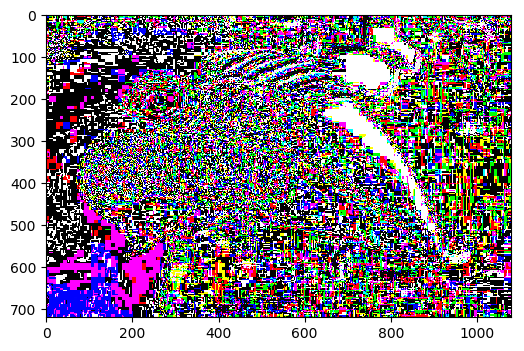

In [8]:
diffim,dtms = cdiff(srun, 2)
plt.imshow(diffim,aspect='auto')
ax.set_xlabel('deg')
ax.set_ylabel('deg')

In [ ]:
#make a n frames diff movie

n = 1
dm = np.zeros(clip.shape)
for i in range(cliplen-n):
    diffim, ms = cdiff(i,n)
    dm[i,:,:,:] = diffim

##play the moive
fstart = 0
vidlen = 49

#new animation function
def diff_animate(i):
    im.set_array(dm[i,:,:])
    return im,

if(anim_flag):
    fig = plt.figure()
    im = plt.imshow(dm[0,:,:,:], aspect='auto')
    ax.set_xlabel('deg')
    ax.set_ylabel('deg')
    anim = animation.FuncAnimation(fig, diff_animate, frames=range(vidlen), interval=int(100/vidlen), blit=False)

    
    display_animation(anim)

In [ ]:
if(anim_flag):
    #save the animation and clear it from our memory
    anim.save('diffim.mp4',fps=fps)
    anim=None

# Cross Correlation

In [ ]:
#average over all pixles
# calculate cross correlation (Dong & Atick 1995a)


##time separation in miliseconds at 25 fps min separation is 40ms.
dtms = 100
#time separation in frames
df = 1
j=0

def get_ccfs(vm,dtms,df,j):
    ccfs = []
    for i in range(ncolorchannels):
        onecc = np.corrcoef(vm[j,0:100,i], vm[j+df,0:100,i])
        ccfs.append(onecc)
    ccfs = np.array(ccfs)
    return(ccfs)

ccfs = get_ccfs(vm,dtms,df,j)

print(ccfs)

## Spatial Fourier Transform of One Raw Image

In [9]:
# from https://code.google.com/archive/p/agpy/downloads
def azimuthalAverage(image, center=None):
    """
    Calculate the azimuthally averaged radial profile.

    image - The 2D image
    center - The [x,y] pixel coordinates used as the center. The default is 
             None, which then uses the center of the image (including 
             fracitonal pixels).
    
    """
    # Calculate the indices from the image
    y, x = np.indices(image.shape)

    if not center:
        center = np.array([(x.max()-x.min())/2.0, (y.max()-y.min())/2.0])

    r = np.hypot(x - center[0], y - center[1])

    # Get sorted radii
    ind = np.argsort(r.flat)
    r_sorted = r.flat[ind]
    i_sorted = image.flat[ind]

    # Get the integer part of the radii (bin size = 1)
    r_int = r_sorted.astype(int)

    # Find all pixels that fall within each radial bin.
    deltar = r_int[1:] - r_int[:-1]  # Assumes all radii represented
    rind = np.where(deltar)[0]       # location of changed radius
    nr = rind[1:] - rind[:-1]        # number of radius bin
    
    # Cumulative sum to figure out sums for each radius bin
    csim = np.cumsum(i_sorted, dtype=complex)
    tbin = csim[rind[1:]] - csim[rind[:-1]]

    radial_prof = tbin / nr
    radial_prof = radial_prof[:int(np.floor(framew/2))-1]

    return radial_prof

In [45]:
def spatialft(image):
    # adpated from http://www.astrobetter.com/blog/2010/03/03/fourier-transforms-of-images-in-python/
    # Take the fourier transform of the image.
    # shift the quadrants around so that low spatial frequencies are in
    # the center of the 2D fourier transformed image.
    
    #raised cosyne window on image to avoid border artifacts
    (dim1,dim2) = np.shape(image)
    oneD = np.hanning(dim1)
    oneD = np.tile(oneD,(dim2,1)).T
    twoD = np.hanning(dim2)
    twoD = np.tile(twoD,(dim1,1))
    cosfilter = oneD*(twoD) 
    
    filtered_im = image * cosfilter
    
    ft2d = np.fft.fftshift(np.fft.fft2(filtered_im))
    
    #average over all orientations
    ft1d = azimuthalAverage(ft2d)
    
    #get the sampling rate
    freq1d = np.fft.fftfreq(framew, d=1./ppd)[0:int(np.floor(framew/2))-1]
    
    return(image, ft2d, ft1d, freq1d)

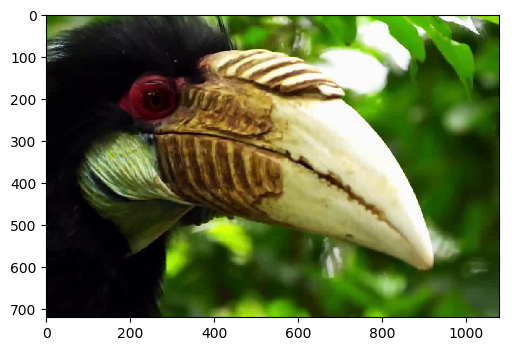

In [44]:
plt.imshow(getsim(srun))

In [60]:
getsim(srun).shape

(720, 1080, 3)

In [46]:
def get_fft1d2dfq():
    images = []
    fft1ds = []
    fft2ds = []
    freqs1d = []
    for i in range(ncolorchannels):
        image, ft2d, ft1d, freq1d = spatialft(getsim(srun)[:,:,i])
        images.append(image)
        fft2ds.append(ft2d)
        fft1ds.append(ft1d)
        freqs1d.append(freq1d)

    return(images, fft2ds, fft1ds, freqs1d)

images, fft2ds, fft1ds, freqs1d = get_fft1d2dfq()
freq1d = freqs1d[0]

In [59]:
fft2ds[0].shape

(720, 1080)

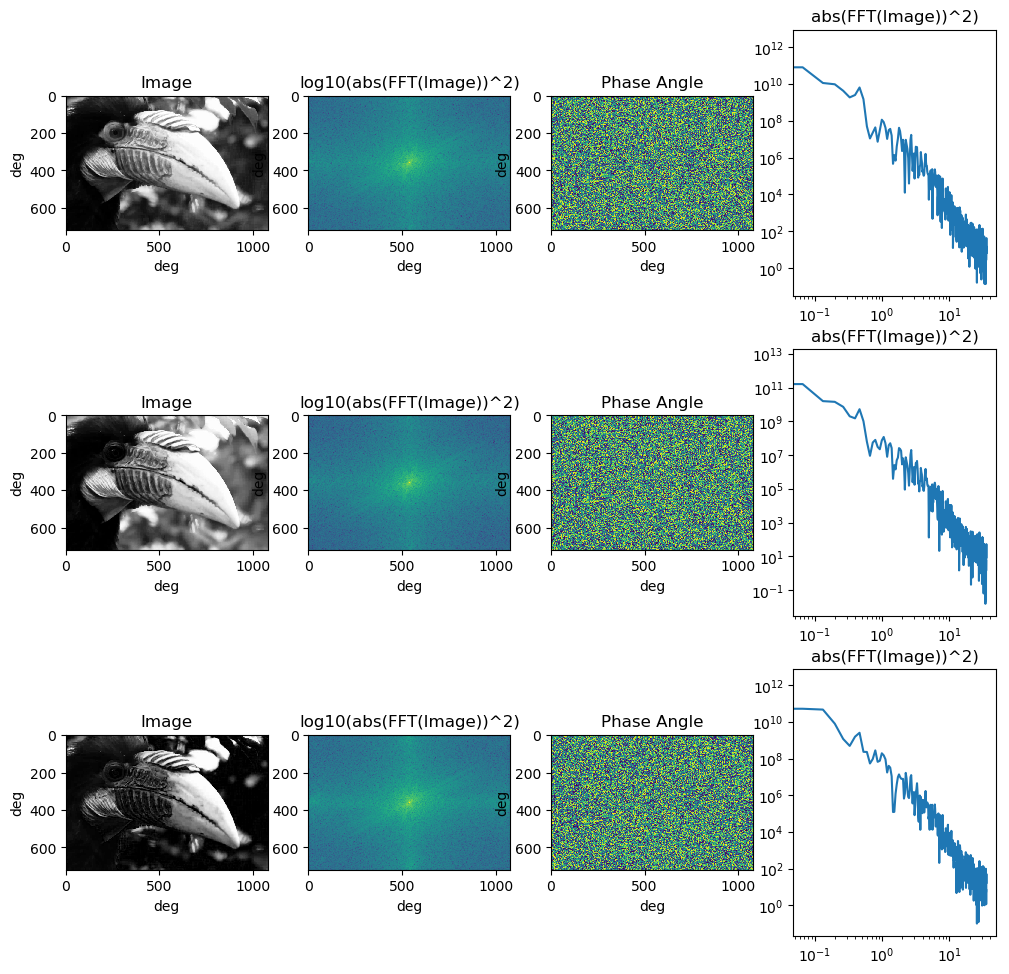

In [47]:
##plotting
#2d power spectra
plt.figure(figsize=(12,12))

for i in range(ncolorchannels):

    ax = plt.subplot(3,4,1+(4*i),title='Image')
    plt.imshow(images[i], cmap='Greys_r', interpolation='none')
    ax.set_xlabel('deg')
    ax.set_ylabel('deg')

    ax = plt.subplot(3,4,2+(4*i),title='log10(abs(FFT(Image))^2)')
    plt.imshow(np.log10(np.abs(fft2ds[i])**2), interpolation='none')
    ax.set_xlabel('deg')
    ax.set_ylabel('deg')
    #plt.colorbar()
    
    ax = plt.subplot(3,4,3+(4*i),title='Phase Angle')
    plt.imshow(np.angle(fft2ds[i]), interpolation='none')
    ax.set_xlabel('deg')
    ax.set_ylabel('deg')
    #plt.colorbar()

    ##azimuthal average
    plt.subplot(3,4,4+(4*i),title='abs(FFT(Image))^2)')
    plt.loglog(freq1d, np.abs(fft1ds[i])**2)

plt.show()

## Phase of the image

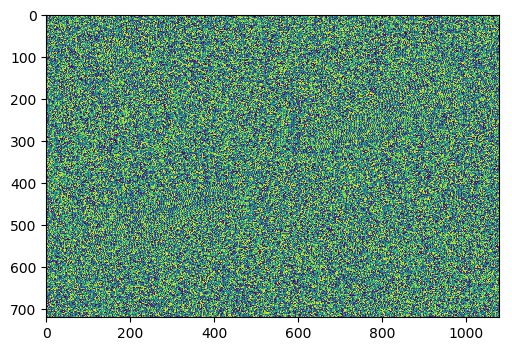

In [65]:
#image = images[0]
image = getsim(srun)[:,:,0]
(dim1,dim2) = np.shape(image)
oneD = np.hanning(dim1)
oneD = np.tile(oneD,(dim2,1)).T
twoD = np.hanning(dim2)
twoD = np.tile(twoD,(dim1,1))
cosfilter = oneD*(twoD) 

filtered_im = image * cosfilter
#ft = np.fft.fftshift(np.fft.fft(filtered_im))
ft = np.fft.fftshift(np.fft.fft2(filtered_im))

#ft = np.fft.fft(image)
test = np.angle(ft)
plt.imshow(test)

In [55]:
image.shape

(720, 1080, 3)

## Average Spatial Fourier Transform over Many Images

In [14]:
def avgspatialft(movie):

    #take fourier transform over each fame
    fttimecube = np.fft.fft2(movie)
    
    #average over frames
    ftframemean = np.fft.fftshift(fttimecube.mean(axis=0))

    ##average over all orientations
    ft1dframemean = azimuthalAverage(ftframemean)
    
    #get the sampling rate
    freq1d = np.fft.fftfreq(framew, d=1./ppd)[0:int(np.floor(framew/2))-1]
    
    return ftframemean, ft1dframemean, freq1d

In [ ]:
#remove previous variables to save memory
ftframemean = None
ft1dframemean = None
freq1d = None

In [ ]:
def get_nchannels_ftframemeans(start,end):

    ftframemeans = []
    ft1dframemeans = []
    freqs1ds = []
    
    for i in range(ncolorchannels):
        ftframemean, ft1dframemean, freq1d = avgspatialft(m[start:end,:,:,i])
        ftframemeans.append(ftframemean)
        ft1dframemeans.append(ft1dframemean)
        freqs1ds.append(freq1d)
    return(ftframemeans, ft1dframemeans, freqs1ds)
    
ftframemeans, ft1dframemeans, freqs1ds = get_nchannels_ftframemeans(0,60)
freq1d = freqs1ds[0]

In [ ]:
##plotting
#2d power spectra
plt.figure(figsize=(12,12))

for i in range(ncolorchannels):
    
    ax = plt.subplot(3,3,1+(3*i),title='FrameMean')
    plt.imshow(np.log10(np.abs(ftframemeans[i])), interpolation='none', extent=[0,framewdeg,0,framehdeg])
    ax.set_xlabel('deg')
    ax.set_ylabel('deg')

    fig = plt.subplot(3,3,2+(3*i),title='abs(FFT(Image)))')
    plt.loglog(freq1d, np.abs(ft1dframemeans[i]))

    fig = plt.subplot(3,3,3+(3*i),title='abs(FFT(Image))^2)')
    plt.loglog(freq1d, np.abs(ft1dframemeans[i])**2)


plt.show()

## Pairwise Probability Distribution (Temporal)

In [15]:
# calculate ppd (Dong & Atick 1995a, Figure 2)
def gettemporalppd(fstart, fend, channel, dtms):
    """
    calculated pairwise probability distribution

    Parameters
    ----------
    fstart: integer frame to start at.
    dtms: integer time in ms. Must be more than 1/framerate*1000
    
    Returns
    -------
    ppd : numpy matrix with pairwise probability distribution.
    
    """
    
    
    ##ensure dt is more than 1 frame
    if(dtms < fr2ms(1,fps)):
        raise Exception('dt must be greater than one frame! 1 frame is', fr2ms(1,fps))    
    #time separation in frames
    df = ms2fr(dtms, fps)
    
    #levels of light intensity
    lil = 256
    #initialize blank matrix to tally pairs
    ppd = np.zeros((lil,lil))
    #go through all pixels and tally up light intensity pairs
    
    for f in range(fstart,fend-df):
        s1 = vm[f,:,channel]
        s2 = vm[f+df,:,channel]
        for i in range(np.size(s1)):
            ppd[s1[i],s2[i]]+=1
    return(ppd)

In [ ]:
dt = 40 #in ms

#dont want to do this calculation every time, it's EXPENSIVE!!!
if(0):
    plt.figure(figsize=(14,10))
    for i in range(ncolorchannels):
        myppd = np.log(gettemporalppd(srun,mrun,i,dt)+0.1)
        ax = plt.subplot(3,3,i+1,title='FrameMean')
        plt.pcolormesh(myppd,cmap='viridis')
        plt.xlim(0,153)
        plt.ylim(0,153)
        plt.colorbar()

## Where are the cuts?

In [ ]:
fchange = []
for f in range(len(m)-1):
    diff,ms = cdiff(f, 1)
    diff = np.sum(np.mean(diff,axis=2))
    fchange.append(diff)

plt.figure(figsize=(5,5))
plt.plot(fchange)

In [ ]:
del(fchange)

## Ignore cuts for now and take 3DFFT

In [16]:
def cos_filter_3d(movie):
    #filter first with cosine window
    (dim1,dim2,dimt) = np.shape(movie)
    d1 = np.hanning(dim1)
    d1 = np.transpose(np.tile(d1,(dim2,dimt,1)),axes=(2,0,1))

    d2 = np.hanning(dim2)
    d2 = np.transpose(np.tile(d2,(dimt,dim1,1)),axes=(1,2,0))

    dt = np.hanning(dimt)
    dt = np.tile(dt,(dim1,dim2,1))

    cosfilter = d1*d2*dt
    
    filtered_movie = cosfilter * movie[:,:,:]

    return(np.array(filtered_movie))

In [17]:
stfts = []
stfqs = []

for i in range(ncolorchannels):
    print('channel {}'.format(i))
    mov = m[:,:,:,i]
    
    stft = cos_filter_3d(mov)
    #print(filtered_clip.shape)
    
    stft = np.fft.rfftn(stft,axes=[0]) #time fourier transform
    stfq = np.fft.fftfreq(m[:,0,0,i].size, d=1./fps)
    stfts.append(stft)
    stfqs.append(stfq)

del(stft)
del(stfq)
#cast to array    
stfts = np.array(stfts)
stfqs = np.array(stfqs)

channel 0


KeyboardInterrupt: 

In [ ]:
#show some sample frequencies
samplefqs = [1,25,50]

plt.figure(figsize=(14,10))
for i in range(ncolorchannels):
    stft = stfts[i]
    for j, fq in enumerate(samplefqs):
        mylppd = np.log10(np.abs(stfts[i,fq,:,:]+1)+0.1)
        ax = plt.subplot(3,3,1+i+(j*3),title='3dft Slice')
        plt.imshow(mylppd,cmap='Greys')
        plt.colorbar()


In [ ]:
if(anim_flag):

    ##play the moive of 3 meaned color channels
    stft = np.mean(stfts,axis=0)

    samplevid = 0
    vidlen = nframes #in frames

    #if we don't take the log you can't see much.
    clip = np.log10(np.abs(stft[samplevid:samplevid+vidlen,:,:])+0.1)
    cliplen = len(clip[:,1,1])
    print(cliplen)

    fig = plt.figure()
    im = plt.imshow(clip[:,:,0], cmap='Greys_r',aspect='auto')
    anim = animation.FuncAnimation(fig, animate, frames=range(cliplen), interval=int(100/cliplen), blit=False)

    display_animation(anim)
    
    
    anim.save('./movies/fps_{}temporalfftlog.mp4'.format(fps), fps=fps,bitrate=-1)
    anim=None

## Average over Many Clips & Make the Football

In [18]:
np.shape(m)

(540, 720, 1080, 3)

In [19]:
def make_tdft(movie,fchunk):
    #if(chunklen%2 != 0):
    #    raise Exception('Error, chunklen must be an even number!')

    nchunks = int(np.floor(len(movie[:,0,0])/fchunk))
    
    print('filtering...')
    movie = cos_filter_3d(movie)
    
    #take spatial fourier transform over each fame
    print('making time cube...')
    fttimecube = np.fft.fft2(movie)
    
    chunklist = []
    
    #break into chunks
    print('{} Chunks: '.format(nchunks), end='')
    for chunk in range(nchunks):
        print('*', end='')
        chunkmov = fttimecube[chunk*fchunk:(chunk+1)*fchunk]
        #temporal FT for each chunk 
        chunklist.append(np.fft.fftn(chunkmov,axes=[0])**2)
    chunklist=np.array(chunklist)
    
    #mean of chunks
    mftchunk = np.mean(chunklist,axis=0)
    del chunklist #save memory
    
    #do fft shifts to make football
    mftchunk = np.fft.fftshift(mftchunk)
    
    #array to hold azmaverage
    azmchunk = np.zeros([fchunk, int(np.floor(framew/2))-1], dtype=complex)
    
    ##spin to get mean
    for f in range(nchunks):
        azmchunk[f] = azimuthalAverage(np.abs(mftchunk[f]))
        
    azmchunk = (azmchunk[int(fchunk/2):] + azmchunk[int(fchunk/2):0:-1]) / 2
      
    #get the sampling rate for azmavgd
    freqspace1d = np.fft.fftfreq(framew, d=1./ppd)[0:int(np.floor(framew/2))-1]
    #get the sampling rates
    freqspacefull = np.fft.fftshift(np.fft.fftfreq(framew, d=1./ppd))
    freqtime = np.fft.fftshift(np.fft.fftfreq(fchunk, d=1./fps))[int(fchunk/2):]
    
    return mftchunk, azmchunk, freqspace1d, freqspacefull, freqtime

In [20]:
mgrey = np.mean(m,axis=-1)

football, azmchunk, fqspace1d, fqspacefull, fqtime = make_tdft(mgrey[:,:,:], fps)


filtering...
making time cube...
9 Chunks: *********

Text(0,0.5,'deg')

Error in callback <function install_repl_displayhook.<locals>.post_execute at 0x7f52cbc55bf8> (for post_execute):


ValueError: values must all be positive

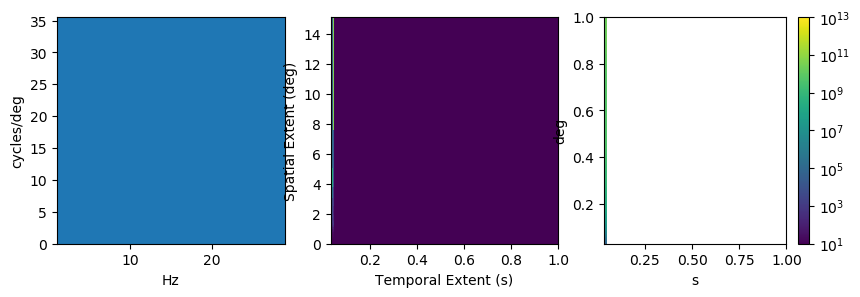

In [21]:
#this works for 30fps movie, but not 60.
plt.figure(figsize=(10,3))

azmabs = np.abs(azmchunk.T[1:,1:])

#amplitude 
ax = plt.subplot(1,3,1)   
#print('amp {}'.format((3*i)+1))
plt.pcolormesh(fqtime[1:], fqspace1d, azmabs,
                   norm=mpl.colors.LogNorm(vmin=azmabs.min(),
                                           vmax=azmabs.max()))
#plt.xlim(fqtime[1],np.max(fqtime))
#plt.ylim(0,np.max(fqspace1d[1:]))
plt.xlabel('Hz')
plt.ylabel('cycles/deg')

#Not sure what this plot is anymore?
ax = plt.subplot(1,3,2)    
plt.pcolormesh(1/(fqtime[1:]),
                1/(fqspace1d[1:]),
                azmabs)

#plt.xlim(np.min(1/(fqtime[1:])),1)
#plt.ylim(np.min(1/(fqspace1d[1:])),1)
plt.xlabel('Temporal Extent (s)')
plt.ylabel('Spatial Extent (deg)')

# kelly plot
ax = plt.subplot(1,3,3)
plt.pcolormesh(1/(fqtime[1:]),
               1/(fqspace1d[1:]),
               np.abs(azmchunk[1:,1:].T), vmax=1e13,
                norm=mpl.colors.LogNorm(vmin=10,
                                         vmax=500))

plt.xlim(np.min(1/(fqtime[1:])),1)
plt.ylim(np.min(1/(fqspace1d[1:])),1)
plt.colorbar()
plt.xlabel('s')
plt.ylabel('deg')

## Sample from Spatial Frequency Spectrum

/home/vasha/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:32: RuntimeWarning: divide by zero encountered in log10
/home/vasha/anaconda3/lib/python3.5/site-packages/matplotlib/ticker.py:2206: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  "Data has no positive values, and therefore cannot be "


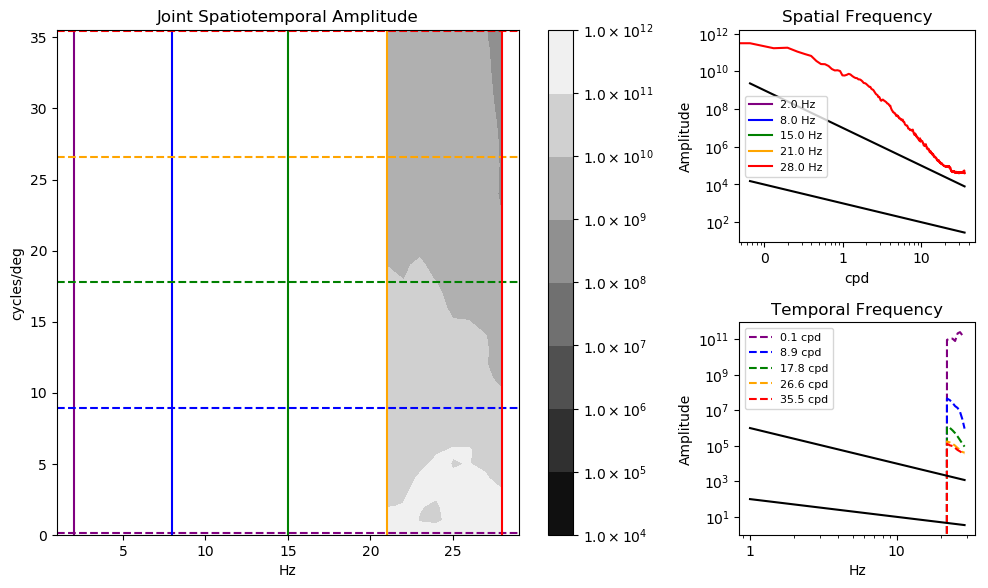

In [24]:
nsamples = 5

buffer = 2
spacemin = buffer
spacemax = len(fqspace1d)-buffer
timemin = buffer
timemax = len(fqtime)-buffer


#colors for lines
spacesamplefqs = np.linspace(spacemin,spacemax,nsamples).astype(int)
timesamplefqs = np.linspace(timemin,timemax,nsamples).astype(int)

spacecolors = np.array(['red', 'orange', 'green', 'blue', 'purple'])[::-1]
timecolors = np.array(['red', 'orange', 'green', 'blue', 'purple'])[::-1]

#make a grid
fig = plt.figure(figsize=(10,6))
full_grid = gsp.GridSpec(2,3)
#layout of subplots
grid_hm = gsp.GridSpecFromSubplotSpec(1,1,subplot_spec=full_grid[0:2,0:2])
grid_time = gsp.GridSpecFromSubplotSpec(1,1,subplot_spec=full_grid[1,2])
grid_space = gsp.GridSpecFromSubplotSpec(1,1,subplot_spec=full_grid[0,2])

#heatmap
axes_hm = plt.subplot(grid_hm[0])
#hm = axes_hm.pcolormesh(fqtime[1:], fqspace1d, np.abs(azmchunk.T[:,1:]),
#              norm=mpl.colors.LogNorm(vmin=np.abs(azmchunk.T[1:,1:]).min(), 
#                                      vmax=np.abs(azmchunk.T[:,1:]).max()),
#                  cmap='Greys_r')

hm = axes_hm.contourf(np.log10(np.abs(azmchunk.T[:,1:])),
                      #norm=mpl.colors.LogNorm(),
                      cmap='gray'
                    )
def fmt(x, pos):
    a, b = '{:.1e}'.format(10**x).split('e')
    b = int(b)
    return r'${} \times 10^{{{}}}$'.format(a, b)

plt.colorbar(hm, format=mpl.ticker.FuncFormatter(fmt))

axes_hm.set_xlim(fqtime[1],np.max(fqtime))
axes_hm.set_ylim(0,np.max(fqspace1d[1:]))
axes_hm.set_title('Joint Spatiotemporal Amplitude')
axes_hm.set_xlabel('Hz')
axes_hm.set_ylabel('cycles/deg')
#add lines
for s in range(nsamples):
    #lines in time
    axes_hm.axvline(fqtime[timesamplefqs[s]],c=timecolors[s],ls='-')
    #lines in space
    axes_hm.axhline(fqspace1d[spacesamplefqs[s]],c=spacecolors[s],ls='--')



#timeplot
axes_time = plt.subplot(grid_time[0])
for i, sf in enumerate(spacesamplefqs):
    axes_time.loglog(fqtime, np.abs(azmchunk.T)[sf,:],'--',
                   label='{0:0.1f} cpd'.format(fqspace1d[sf]),
                   c=spacecolors[i])
axes_time.plot(fqtime[1:],1e2/(fqtime[1:]),c='black') # 1/f line
axes_time.plot(fqtime[1:],1e6/(fqtime[1:]**2),c='black') # 1/f^2 line
axes_time.set_title('Temporal Frequency')
axes_time.set_xlabel('Hz')
axes_time.set_ylabel('Amplitude') 
#axes_time.set_xlim(fqtime[1],30)
axes_time.xaxis.set_major_formatter(mpl.ticker.FormatStrFormatter('%d'))
axes_time.legend(fontsize=8)

#spaceplot
axes_space = plt.subplot(grid_space[0])
for i, sf in enumerate(timesamplefqs):
    axes_space.loglog(fqspace1d, np.abs(azmchunk.T)[:,sf],
                    label='{0:0.1f} Hz'.format(fqtime[sf]),
                    c=timecolors[i])
axes_space.plot(fqspace1d[1:],1e3/(fqspace1d[1:]),c='black') # 1/f line
axes_space.plot(fqspace1d[1:],1e7/(fqspace1d[1:]**2),c='black') # 1/f^2 line
axes_space.set_title('Spatial Frequency')
axes_space.set_xlabel('cpd')
axes_space.set_ylabel('Amplitude')
#axes_space.set_xlim(fqspace1d[1],50)
axes_space.xaxis.set_major_formatter(mpl.ticker.FormatStrFormatter('%d'))
axes_space.legend(fontsize=8)


plt.tight_layout()

/home/vasha/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:31: RuntimeWarning: divide by zero encountered in log10
/home/vasha/anaconda3/lib/python3.5/site-packages/matplotlib/ticker.py:2206: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  "Data has no positive values, and therefore cannot be "


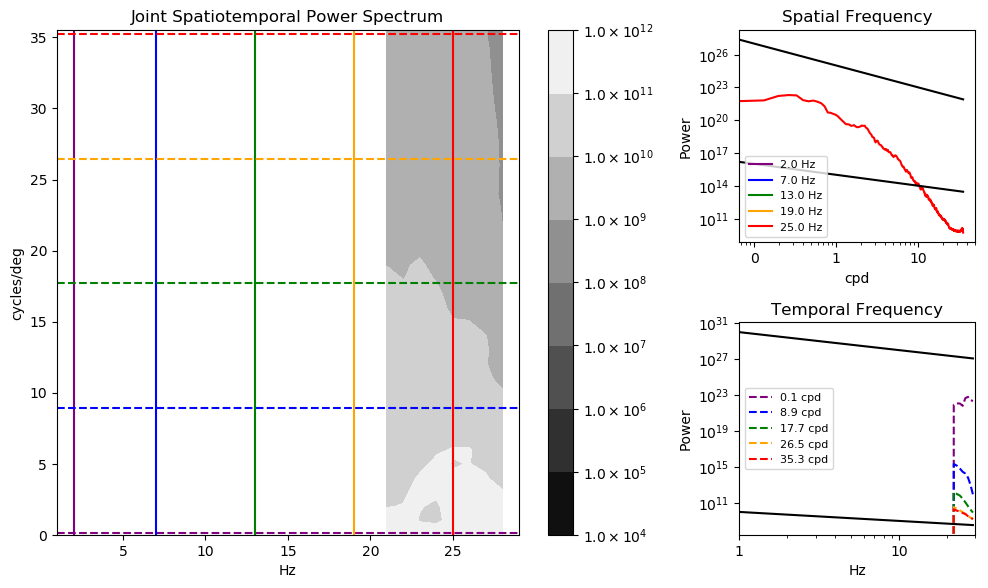

In [25]:
nsamples = 5

spacemin = 2
spacemax = len(fqspace1d)-nsamples
timemin = 2
timemax = len(fqtime)-nsamples

azmps = np.abs(azmchunk.T)**2

#colors for lines
spacesamplefqs = np.linspace(spacemin,spacemax,nsamples).astype(int)
timesamplefqs = np.linspace(timemin,timemax,nsamples).astype(int)

spacecolors = np.array(['red', 'orange', 'green', 'blue', 'purple'])[::-1]
timecolors = np.array(['red', 'orange', 'green', 'blue', 'purple'])[::-1]

#make a grid
fig = plt.figure(figsize=(10,6))
full_grid = gsp.GridSpec(2,3)
#layout of subplots
grid_hm = gsp.GridSpecFromSubplotSpec(1,1,subplot_spec=full_grid[0:2,0:2])
grid_time = gsp.GridSpecFromSubplotSpec(1,1,subplot_spec=full_grid[1,2])
grid_space = gsp.GridSpecFromSubplotSpec(1,1,subplot_spec=full_grid[0,2])

#heatmap
axes_hm = plt.subplot(grid_hm[0])
#hm = axes_hm.pcolormesh(fqtime[1:], fqspace1d, azmps[:,1:],
#              norm=mpl.colors.LogNorm(vmin=azmps[:,1:].min(), 
#                                      vmax=azmps[:,1:].max()),
#                  cmap='Greys_r')
axes_hm.contourf(np.log10(azmps[:,1:]),cmap='gray') #remove dc component (0hz) from time and 0 cycles/deg from space
axes_hm.set_xlim(fqtime[1],np.max(fqtime))
axes_hm.set_ylim(0,np.max(fqspace1d[1:]))
axes_hm.set_title('Joint Spatiotemporal Power Spectrum')
axes_hm.set_xlabel('Hz')
axes_hm.set_ylabel('cycles/deg')
#add lines
for s in range(nsamples):
    #lines in time
    axes_hm.axvline(fqtime[timesamplefqs[s]],c=timecolors[s],ls='-')
    #lines in space
    axes_hm.axhline(fqspace1d[spacesamplefqs[s]],c=spacecolors[s],ls='--')
plt.colorbar(hm, format=mpl.ticker.FuncFormatter(fmt))


#timeplot
axes_time = plt.subplot(grid_time[0])
for i, sf in enumerate(spacesamplefqs):
    axes_time.loglog(fqtime, azmps[sf,:],'--',
                   label='{0:0.1f} cpd'.format(fqspace1d[sf]),
                   c=spacecolors[i])
axes_time.plot(fqtime[1:],1e10/(fqtime[1:]),c='black') # 1/f line
axes_time.plot(fqtime[1:],1e30/(fqtime[1:]**2),c='black') # 1/f^2 line
axes_time.set_title('Temporal Frequency')
axes_time.set_xlabel('Hz')
axes_time.set_ylabel('Power') 

axes_time.set_xlim(fqtime[1],30)
axes_time.xaxis.set_major_formatter(mpl.ticker.FormatStrFormatter('%d'))
axes_time.legend(fontsize=8)

#spaceplot
axes_space = plt.subplot(grid_space[0])
for i, sf in enumerate(timesamplefqs):
    axes_space.loglog(fqspace1d, azmps[:,sf],
                    label='{0:0.1f} Hz'.format(fqtime[sf]),
                    c=timecolors[i])
axes_space.plot(fqspace1d[1:],1e15/(fqspace1d[1:]),c='black') # 1/f line
axes_space.plot(fqspace1d[1:],1e25/(fqspace1d[1:]**2),c='black') # 1/f^2 line
axes_space.set_title('Spatial Frequency')
axes_space.set_xlabel('cpd')
axes_space.set_ylabel('Power')
axes_space.set_xlim(fqspace1d[1],50)
axes_space.xaxis.set_major_formatter(mpl.ticker.FormatStrFormatter('%d'))
axes_space.legend(fontsize=8)

plt.tight_layout()

## Low Pass Filter Every Other Frame

In [ ]:
def lpf2sigma(cutoff):
    """
    Converts cuttoff frequency in cycles/deg
    to a value for sigma (in pixels) for a gaussian kernel.
    Used for low pass filtering for FWHM

    Parameters
    ----------
    fcu: integer Low pass frequncy cuttoff (in cycles per deg)
 
    Returns
    -------
    sigma : float value for sigma (in pixels)
    
    """
    #http://www.ltrr.arizona.edu/~dmeko/notes_8.pdf
    cpp = cutoff/ppd
    sigma = (1./cpp)/6
    return(sigma)


## function to low pass filter frames
def lpf_frames(movie,plpf,cutfqdeg):
    """
    Low pass filters a fraction of frames in a movie.

    Parameters
    ----------
    movie:   numpy matrix with pixel values for movie
    plpf:    percentage of frames to low pass filter ie nlpf=0.25 means 25% of frames are lpf'd
    cutfq:   cutoff frequency for blurring in cycles per degree
    
    Returns
    -------
    lpfmovie       : numpy matrix with pixel values for low pass filtered movie.
    
    """
    
    #calculate sigma for gaussian kernel
    
    cutfqpx = ppd/cutfqdeg #deg2px(1./cutfqdeg) #degrees per cycle to pixels per cycle
    sig = lpf2sigma(1./cutfqpx) #cycles per pixel to pixels
    
    lpfmov = np.zeros_like(movie)
    
    for i in range(len(movie[:,0,0])):
        frame = movie[i,:,:]
        if ((plpf < 0.5) & (i % round(1/plpf) == 0)) | (i % round(1/(1-plpf)) != 0):
            gain = ndimage.gaussian_filter(np.ones_like(frame), sigma=sig)
            filtered = ndimage.gaussian_filter(frame, sigma=sig)
            lpfmov[i,:,:] = filtered/gain
        else:
            lpfmov[i,:,:] = frame
    return(lpfmov)

In [ ]:
#make filtered movie
pframes = 0.5
cufq = 5
fmov = lpf_frames(m,pframes,cufq)
# fmov = lpf_frames(fmov,0.5,1.5)
# fmov = lpf_frames(fmov,0.5,1.5)
##call function to take mean FT in space.
filtered_football, filtered_azmchunk, filtered_fqspace1d, filtered_fqspacefull, filtered_fqtime = make_tdft(fmov, nframes)

In [ ]:
## animate, play, and save the moive, unfiltered, filtered, and separated into even/odd 
samplevid = chase
vidlen = 2000

pframe = 0.5
cufqs = [1,3,5,8]

for cufq in cufqs:
    print('cufq'+str(cufq))

    clip = fmov[samplevid:samplevid+vidlen,:,:]
    cliplen = len(clip[:,1,1])

    #encode together
    if(1):
        fig = plt.figure()
        im = plt.imshow(clip[0,:,:], cmap='Greys_r', extent=[0,framewdeg,0,framehdeg])
        ax.set_xlabel('deg')
        ax.set_ylabel('deg')
        anim = animation.FuncAnimation(fig, animate, frames=range(cliplen), interval=int(100/cliplen), blit=False)
    #display_animation(anim)
    anim.save('./movies/'+str(samplevid)+'_fps'+str(fps)+'_lpfpcnt'+str(pframes)+'_fq'+str(cufq)+'_sig.mp4', fps=fps)


    #encode separate
    evens = [x for x in range(samplevid,samplevid+vidlen) if x%2 == 0]
    clip = fmov[evens,:,:]
    cliplen = len(clip[:,1,1])
    if(1):
        fig = plt.figure()
        im = plt.imshow(clip[0,:,:], cmap='Greys_r', extent=[0,framewdeg,0,framehdeg])
        ax.set_xlabel('deg')
        ax.set_ylabel('deg')
        anim = animation.FuncAnimation(fig, animate, frames=range(cliplen), interval=int(100/cliplen), blit=False)
        anim.save('./movies/'+str(samplevid)+'odds_fps'+str(fps)+'_lpfpcnt'+str(pframes)+'_fq'+str(cufq)+'_sig.mp4', fps=fps)

    odds = [x for x in range(samplevid,samplevid+vidlen) if x%2 == 1]
    clip = fmov[odds,:,:]
    cliplen = len(clip[:,1,1])
    if(1):
        fig = plt.figure()
        im = plt.imshow(clip[0,:,:], cmap='Greys_r', extent=[0,framewdeg,0,framehdeg])
        ax.set_xlabel('deg')
        ax.set_ylabel('deg')
        anim = animation.FuncAnimation(fig, animate, frames=range(cliplen), interval=int(100/cliplen), blit=False)
        anim.save('./movies/'+str(samplevid)+'evens_fps'+str(fps)+'_lpfpcnt'+str(pframes)+'_fq'+str(cufq)+'_sig.mp4', fps=fps)


    ##make corresponding unfiltered movie
    from pathlib import Path

    my_file = Path('./movies/'+str(samplevid)+'_original.mp4')
    if not(my_file.is_file()):
        clip = m[samplevid:samplevid+vidlen,:,:]
        cliplen = len(clip[:,1,1])

        fig = plt.figure()
        im = plt.imshow(clip[0,:,:], cmap='Greys_r', extent=[0,framewdeg,0,framehdeg])
        ax.set_xlabel('deg')
        ax.set_ylabel('deg')
        anim = animation.FuncAnimation(fig, animate, frames=range(cliplen), interval=int(100/cliplen), blit=False)

        #display_animation(anim)
        anim.save('./movies/'+str(samplevid)+'_fps'+str(fps)+'_original.mp4', fps=fps)

In [ ]:
#make a grid
fig = plt.figure(figsize=(10,6))
full_grid = gsp.GridSpec(2,3)
#layout of subplots
grid_hm = gsp.GridSpecFromSubplotSpec(1,1,subplot_spec=full_grid[0:2,0:2])
grid_time = gsp.GridSpecFromSubplotSpec(1,1,subplot_spec=full_grid[1,2])
grid_space = gsp.GridSpecFromSubplotSpec(1,1,subplot_spec=full_grid[0,2])

#heatmap
axes_hm = plt.subplot(grid_hm[0])
hm = axes_hm.pcolormesh(filtered_fqtime[1:], filtered_fqspace1d, np.abs(filtered_azmchunk.T[:,1:]),
              norm=mpl.colors.LogNorm(vmin=np.abs(filtered_azmchunk.T[1:,1:]).min(), 
                                      vmax=np.abs(filtered_azmchunk.T[:,1:]).max()),
                  cmap='Greys_r')
axes_hm.set_xlim(filtered_fqtime[1],np.max(filtered_fqtime))
axes_hm.set_ylim(0,np.max(filtered_fqspace1d[1:]))
axes_hm.set_title('Joint Spatiotemporal Amplitude')
axes_hm.set_xlabel('Hz')
axes_hm.set_ylabel('cycles/deg')
#add lines
for s in range(nsamples):
    #lines in time
    axes_hm.axvline(filtered_fqtime[timesamplefqs[s]],c=timecolors[s],ls='-')
    #lines in space
    axes_hm.axhline(filtered_fqspace1d[spacesamplefqs[s]],c=spacecolors[s],ls='--')
plt.colorbar(hm)


#timeplot
axes_time = plt.subplot(grid_time[0])
for i, sf in enumerate(spacesamplefqs):
    axes_time.loglog(filtered_fqtime, np.abs(filtered_azmchunk.T)[sf,:],'--',
                   label='{0:0.1f} cpd'.format(filtered_fqspace1d[sf]),
                   c=spacecolors[i])
axes_time.plot(filtered_fqtime[1:],100/(filtered_fqtime[1:]),c='black') # 1/f line
axes_time.plot(filtered_fqtime[1:],100000/(filtered_fqtime[1:]**2),c='black') # 1/f^2 line
axes_time.set_title('Temporal Frequency')
axes_time.set_xlabel('Hz')
axes_time.set_ylabel('Amplitude')
axes_time.set_xlim(filtered_fqtime[1],30)
axes_time.xaxis.set_major_formatter(mpl.ticker.FormatStrFormatter('%d'))
axes_time.legend(fontsize=8)

#spaceplot
axes_space = plt.subplot(grid_space[0])
for i, sf in enumerate(timesamplefqs):
    axes_space.loglog(filtered_fqspace1d, np.abs(filtered_azmchunk.T)[:,sf],
                    label='{0:0.1f} Hz'.format(filtered_fqtime[sf]),
                    c=timecolors[i])
axes_space.plot(filtered_fqspace1d[1:],100/(filtered_fqspace1d[1:]),c='black') # 1/f line
axes_space.plot(filtered_fqspace1d[1:],5000/(filtered_fqspace1d[1:]**2),c='black') # 1/f^2 line
axes_space.set_title('Spatial Frequency')
axes_space.set_xlabel('cpd')
axes_space.set_ylabel('Amplitude') 
axes_space.set_xlim(filtered_fqspace1d[1],10)
axes_space.xaxis.set_major_formatter(mpl.ticker.FormatStrFormatter('%d'))
axes_space.legend(fontsize=8)


plt.tight_layout()

In [ ]:
filtered_azmps = np.abs(filtered_azmchunk.T)**2

#make a grid
fig = plt.figure(figsize=(10,6))
full_grid = gsp.GridSpec(2,3)
#layout of subplots
grid_hm = gsp.GridSpecFromSubplotSpec(1,1,subplot_spec=full_grid[0:2,0:2])
grid_time = gsp.GridSpecFromSubplotSpec(1,1,subplot_spec=full_grid[1,2])
grid_space = gsp.GridSpecFromSubplotSpec(1,1,subplot_spec=full_grid[0,2])

#heatmap
axes_hm = plt.subplot(grid_hm[0])
hm = axes_hm.pcolormesh(fqtime[1:], fqspace1d, filtered_azmps[:,1:],
              norm=mpl.colors.LogNorm(vmin=filtered_azmps[:,1:].min(), 
                                      vmax=filtered_azmps[:,1:].max()),
                  cmap='Greys_r')
axes_hm.set_xlim(fqtime[1],10)#np.max(fqtime))
axes_hm.set_ylim(0,np.max(fqspace1d[1:]))
axes_hm.set_title('Joint Spatiotemporal Power Spectrum')
axes_hm.set_xlabel('Hz')
axes_hm.set_ylabel('cycles/deg')
#add lines
for s in range(nsamples):
    #lines in time
    axes_hm.axvline(fqtime[timesamplefqs[s]],c=timecolors[s],ls='-')
    #lines in space
    axes_hm.axhline(fqspace1d[spacesamplefqs[s]],c=spacecolors[s],ls='--')
plt.colorbar(hm)


#timeplot
axes_time = plt.subplot(grid_time[0])
for i, sf in enumerate(spacesamplefqs):
    axes_time.loglog(fqtime, filtered_azmps[sf,:],'--',
                   label='{0:0.1f} cpd'.format(fqspace1d[sf]),
                   c=spacecolors[i])
axes_time.plot(fqtime[1:],1e5/(fqtime[1:]),c='black') # 1/f line
axes_time.plot(fqtime[1:],1e10/(fqtime[1:]**2),c='black') # 1/f^2 line
axes_time.set_title('Temporal Frequency')
axes_time.set_xlabel('Hz')
axes_time.set_ylabel('Power') 
axes_time.set_xlim(fqtime[1],30) #fqtime[-1])
axes_time.xaxis.set_major_formatter(mpl.ticker.FormatStrFormatter('%d'))
axes_time.legend(fontsize=8)

#spaceplot
axes_space = plt.subplot(grid_space[0])
for i, sf in enumerate(timesamplefqs):
    axes_space.loglog(fqspace1d, filtered_azmps[:,sf],
                    label='{0:0.1f} Hz'.format(fqtime[sf]),
                    c=timecolors[i])
axes_space.plot(fqspace1d[1:],1e5/(fqspace1d[1:]),c='black') # 1/f line
axes_space.plot(fqspace1d[1:],1e8/(fqspace1d[1:]**2),c='black') # 1/f^2 line
axes_space.set_title('Spatial Frequency')
axes_space.set_xlabel('cpd')
axes_space.set_ylabel('Power')
axes_space.set_xlim(fqspace1d[1],10)#fqspace1d[-1])
axes_space.xaxis.set_major_formatter(mpl.ticker.FormatStrFormatter('%d'))
axes_space.legend(fontsize=8)


plt.tight_layout()

In [ ]:
difference = np.abs(azmchunk) - np.abs(filtered_azmchunk)

plt.pcolormesh(filtered_fqtime[1:], filtered_fqspace1d, difference.T[:,1:],
               cmap='Greys_r')
plt.xlim(filtered_fqtime[1],np.max(filtered_fqtime))
plt.ylim(0,np.max(filtered_fqspace1d[1:]))
plt.title('Amplitude of Original minus Filtered')
plt.xlabel('Hz')
plt.ylabel('cycles/deg')

plt.colorbar()

In [ ]:
difference = np.log10(np.abs(azmps) - np.abs(filtered_azmps))

plt.pcolormesh(filtered_fqtime[1:], filtered_fqspace1d, difference[:,1:],
               cmap='Greys_r')
plt.xlim(filtered_fqtime[1],np.max(filtered_fqtime))
plt.ylim(0,np.max(filtered_fqspace1d[1:]))
plt.title('Power of Original minus Filtered')
plt.xlabel('Hz')
plt.ylabel('cycles/deg')

plt.colorbar()

## Cut out a spatio/temporal corner in Fourier space so we don't have flicker

In [ ]:
def make_fft_filter(shape, scaling_space=1, scaling_time=1, cut_strength=1):
    indices = np.indices(shape)    
    filt = np.exp(-np.sqrt((scaling_time*indices[0]/shape[0])**2
                           + (scaling_space*indices[1]/shape[1])**2 
                           + (scaling_space*indices[2]/shape[2])**2)**(2*cut_strength))
    return(filt)

def animate_filt(i):
    im.set_array(filtcolormovie[i,:,:,:])
    return im,

In [ ]:
#choose a clip
samplevid = 0
vidlen = 49

clip = m[samplevid:samplevid+vidlen,:,:,:]

#vals for filtering
#parameters for filtering
#ss =  1 #a number between 0 and 1+, where 1 cutts off few high spatial fqs
ss_vals = [0.5,1] #[0,0.5,0.75] #[0,0.5,0.75,1]
#st =  1 #a number between 0 and 1+, where 1 cutts off few high temporal fqs
st_vals = [0.25,0.5,1]#,1] #[0,0.5,0.75] #[0,0.5,0.75,1]
#co_str = 3 # a number between 1 and 10, how steep the gaussian cuttoff is.
co_str_vals = [1,3,6] #,3,6] #[1,3,6,8]  

#loop through vals
for ss in ss_vals:
    for st in st_vals:
        for co_str in co_str_vals:
            print('Filtering Movie: SS='+str(ss)+ ' ST='+str(st)+ ' CO='+str(co_str)+'...')
            #make a filter with these parameters
            print('making filter...')
            filt = make_fft_filter(clip[:,:,:,1].shape, 
                                   scaling_space = ss, scaling_time=st, cut_strength=co_str)
            filtcolormovie = np.zeros(np.shape(clip))
            for i in range(ncolorchannels):
                print('Color Channel: {}'.format(i))
                clipbigfootball = np.fft.fftn(clip[:,:,:,i])
                filt_football = clipbigfootball * filt
                filt_movie = np.abs(np.fft.ifftn(filt_football))
                #trick to match contrast
                #filt_movie[0,0,0] = np.min(clip[:,:,i])
                #filt_movie[0,0,1] = np.max(clip[:,:,i])

                filtcolormovie[:,:,:,i] = filt_movie

            filtcolormovie = np.array(filtcolormovie).astype('uint8')
            fig = plt.figure();
            im = plt.imshow(filtcolormovie[0,:,:,:]);
            anim = animation.FuncAnimation(fig, animate_filt, frames=vidlen, interval=int(100/vidlen), blit=False)
            print('Saving Movie')
            anim.save('./movies/newmovies/' + str(vidlen) + '_fps' + str(fps) + '_scalespace' + str(ss) + '_scaletime' + str(st) + 'costr'+str(co_str)+'_nocontrast.mp4', fps=fps)

            print('Done!')

In [ ]:
display_animation(anim)

In [ ]:
fig = plt.figure(figsize=(12,5))
axis = plt.subplot(1,2,1)
plt.imshow(filtcolormovie[10,:,:],extent=[0,framewdeg,0,framehdeg])
axis = plt.subplot(1,2,2)
plt.imshow(np.abs(clip[10,:,:]), extent=[0,framewdeg,0,framehdeg])

In [ ]:
np.save('./filteredfootball.npy', filt_football)
np.save('./filteredmovie.npy', filt_movie)
filt_football = np.load('./filteredfootball.npy')
filt_movie = np.load('./filteredmovie.npy')

In [ ]:
plt.figure(figsize=(8,6))
plt.pcolormesh(np.fft.rfftfreq(vidlen*2, 1/fps),
               np.fft.rfftfreq(filt.shape[1]*2, 1/ppd),
               np.reshape(filt[:,:,1],(vidlen,filt.shape[1])).T,cmap='Greys_r',
               vmin=0, vmax=1)
plt.title('Fourier Filter: SS/SR/ST = {}/{}/{}'.format(ss,st,co_str))

plt.xlabel('Hz')
plt.ylabel('cycles/deg')

plt.colorbar()

## Meeting with Bruno - Notes to update:  

### Action Items (bold when done)

**Change to chunks so the Rayleigh frequency is on the order of something sensible. Right now it's 1 cycle per the entire movie. Averaging over the chunks will also make the data better.** 

**.64 cycles/images max (nuyquist)**

**0.5 cycles per pixel**

**Add powers then take sqrt **

Discreet fourier transform - Need tapering function on outside of image (use raised cosine)  Do this in time also

**Urs' duck movie (ask dyaln for this) might be a better movie than the VH movie.  **  
**Instead - got movie from Gallant Lab**

For motion sharpening:
Need to figure out the encoding. Also ask Dylan about ffmpeg, this might be a good way to do it.  

**Adjust for a DC gain of 1 by ensuring filter sums to 1.**

Coinsider boosting low pass frames

Or blending in high pass filter over time (so we don't just have hole - this may stop the flickering. 

## optimal spatial & temporal filters

From Dong, D. W., & Atick, J. J. (1995). Temporal Decorrelation: A Theory of Lagged and Nonlagged Responses in the Lateral Geniculate Nucleus.

$$ K_{LGN}(t) = t(1-\pi w_c t)e^{-2\pi wct} $$

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
#cuttoff frequency
wc = 5.5 

#spatial
s = np.linspace(-1,1)
sigpush = 0.05
sigpull = 0.1
kretina = 0.015*np.exp(-(s)**2/((2*sigpush)**2)) - \
          0.005*np.exp(-(s)**2/((2*sigpull)**2))      #s/((1+(s**2)/(wc**2))**(3/2))

#temporal
t = np.linspace(0,8*0.033)
klgn = t*(1-np.pi*wc*t)*np.exp(-2*np.pi*wc*t)

# Two subplots, unpack the axes array immediately
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
ax1.plot(s,kretina)
ax1.set_title('Optimal Spatial Filter')
l = plt.axhline(0,c='black')
ax1.set_xlabel('Space')
ax1.set_ylabel('Response')
ax2.plot(t,klgn)
ax2.axhline(0,c='black')
ax2.set_title('Optimal Temporal Filter')
ax2.set_xlabel('Time')



In [ ]:
#spatial
s_ft = np.fft.fftshift(np.fft.fft(kretina))
s_fq = np.fft.fftshift(np.fft.fftfreq(len(kretina)))

#temporal
t_ft = np.fft.fftshift(np.fft.fft(klgn))
t_fq = np.fft.fftshift(np.fft.fftfreq(len(klgn)))

# Two subplots, unpack the axes array immediately
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
ax1.plot(s_fq,s_ft)
ax1.set_title('Optimal Spatial Filt: Freq Domain')
#l = plt.axhline(0,c='black')
ax1.set_xlabel('Spatial Freq')
ax1.set_ylabel('Amplitude')
ax2.plot(t_fq,t_ft)
#ax2.axhline(0,c='black')
ax2.set_title('Optimal Temporal Filt: Freq Domain')
ax2.set_xlabel('Temporal Freq')
ax1.set_ylabel('Amplitude')


$$ Cost = -I(m,c) $$